In [1]:
import numpy as np
from skimage import io, draw, measure, morphology
from matplotlib import pyplot as plt
import torch

import tqdm
import time
from multiprocessing import Pool
from scipy.spatial.distance import cdist

from papyrus_matching.train import LitPapyrusTR
from loader.inference import InferenceDataset


In [1]:
%cd ..

/raid/homes/nicola.messina/workspace/papyri/papyrus-matching


/raid/homes/nicola.messina/anaconda3/envs/papyri/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
root = 'data/for_inference'
image_name_a = root + "/test_fragment_easy1_L.png"
image_name_b = root + "/test_fragment_hard1_L.png" # "/test_fragment_easy1_R.png"

from torchvision import transforms as T
transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
mask_transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
dset = InferenceDataset(image_name_a, image_name_b, pad=25, perimeter_points=100, transform=transf, mask_transform=mask_transf, return_final_image=True)

In [3]:
# load the model
model_path = "runs/lightning_logs/version_9_pretrained_frozen++_strong_aug_10px_shift_10px_tangent_shift_20px_pad/checkpoints/epoch=22-step=4853.ckpt"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = LitPapyrusTR.load_from_checkpoint(model_path)
encoder = model.eval().to(device)

[INFO] Trainable parameters: 8964768/30408712 (29.48%)


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


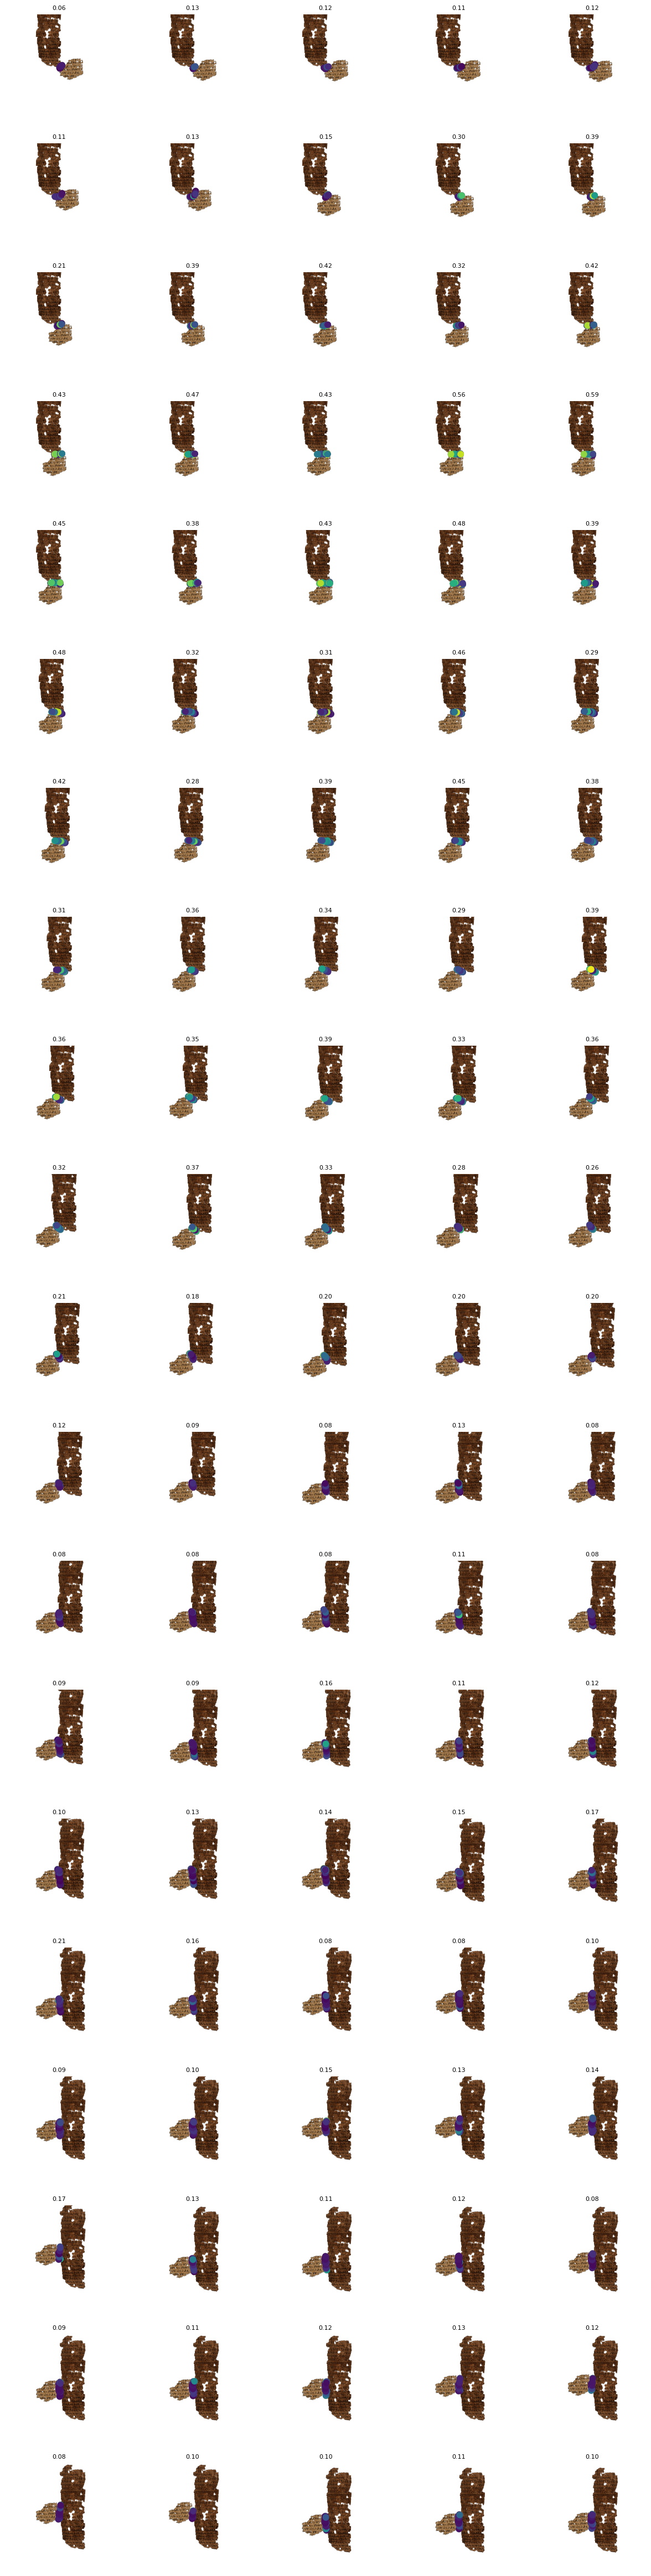

In [5]:
# show images organizing them in a grid
fig = plt.figure(figsize=(15, 60))
num_samples = min(100, len(dset))

for i in tqdm.trange(num_samples):
    start = time.time()
    data = dset[i]
    end_loading = time.time()
    patches, image = data

    image, t_a_full, _, _ = image

    patches_imgs, t_a_patches, _, middle_points, _, _ = zip(*patches)
    patches_imgs = torch.stack(patches_imgs).to(device)

    scores = encoder(patches_imgs)
    with torch.no_grad():
        scores = torch.sigmoid(scores).cpu()
    end_inference = time.time()
    # print(f"Loading time: {end_loading - start:.3f}s, Inference time: {end_inference - end_loading:.3f}s")

    ax = fig.add_subplot(20, 5, i + 1)
    # disable axis
    ax.axis('off')
    image_np = image
    for score, mp in zip(scores, middle_points):
        color = plt.cm.viridis(score)
        # draw red_dots at the center of the full_image
        center = mp + t_a_full
        rr, cc = draw.disk(center, 110, shape=image_np.shape[:2])
        image_np[rr, cc] = (color[:3] * 255).astype(np.uint8)
        image_np[rr, cc, 3] = 255 # set alpha to 255
    pooled_score = scores.mean()
    ax.set_title(f"{pooled_score:.2f}", fontdict={'size': 8})
    ax.imshow(image_np)
